# Financial Analysis and Monte Carlo Simulation

In [155]:
# Import dependencies and libraries

import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import numpy as np
import hvplot.pandas
# from alpha_vantage.timeseries import TimeSeries
# from alpha_vantage.cryptocurrencies import CryptoCurrencies
import json
import questionary
from MCForecastTools import MCSimulation
%matplotlib inline
import requests

In [156]:
# AlphaAvantage API Key
API_Key = 'A9HTPYBVOW6MI2HN'

:Overlay
   .Curve.I  :Curve   [Date]   (close)
   .Curve.II :Curve   [Date]   (close)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
count           100.000000
mean              1.194764
std               1.529276
min               0.045532
25%               0.220354
50%               0.527999
75%               1.399999
max               7.274647
95% CI Lower      0.114891
95% CI Upper      5.869262
Name: 252, dtype: float64


'done'

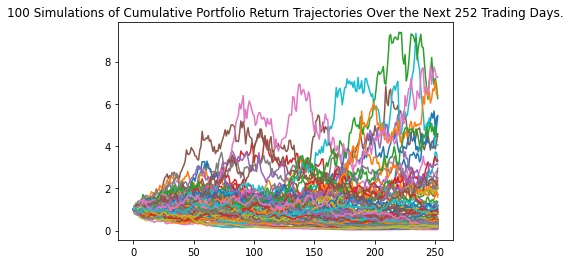

In [133]:
# Function that takes 2 tickers as inputs and returns plot of historical data. Also, runs Monte Carlo Simulation.


def display_data(apikey, ticker1, ticker2, is_etf, num_trading_day=252, num_sim=100):

    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker1}&outputsize=full&apikey={API_Key}&datatype=csv'
    df_base = pd.read_csv(url)
    df_base['Date'] = pd.to_datetime(df_base['timestamp'])
    df_base = df_base.set_index('Date')
    df_plot_base = df_base.hvplot.line(
            x = 'Date',
            y = 'close'
        )

    if is_etf == 'y':
        url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker2}&outputsize=full&apikey={API_Key}&datatype=csv'
        df = pd.read_csv(url)
        df['Date'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('Date')

        df_plot = df.hvplot.line(
            x = 'Date',
            y = 'close'
        )

        p = df_plot_base * df_plot

    elif is_etf == 'n':
        url2 = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={ticker2}&market=CNY&outputsize=full&apikey={apikey}&datatype=csv'
        df = pd.read_csv(url2)
        df['Date'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('Date')

        df_plot = df.hvplot.line(
            x = 'Date',
            y = 'close (USD)'
        )

        p = df_plot_base + df_plot

    else:
        return "Sorry, inputs are incorrect, please try again is_etf is y/n option."
    
    display(p)

    t1 = df_base[['open', 'high', 'low', 'close', 'volume']]
    t2 = df[['open', 'high', 'low', 'close', 'volume']]
    to_merge_dict = {ticker1: t1, ticker2: t2}
    merged_df = pd.concat(to_merge_dict.values(), axis=1, keys=to_merge_dict.keys())
    simulation = MCSimulation(
        portfolio_data = merged_df,
        weights=[0.25, 0.75],
        num_simulation = num_sim,
        num_trading_days = num_trading_day)
    simulation.calc_cumulative_return()
    simulation.plot_simulation()
    simulation_statistics = simulation.summarize_cumulative_return()
    print(simulation_statistics)
    
    return 'done'
    # return df, df_base

    

display_data(apikey=API_Key, ticker1='SPY',ticker2='AAPL', is_etf='y', num_trading_day=252, num_sim=100)



In [151]:
 url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&outputsize=full&apikey={API_Key}&datatype=csv'
df_base = pd.read_csv(url)
df_base['Date'] = pd.to_datetime(df_base['timestamp'])
df_base = df_base.set_index('Date')
df_base.head()

,timestamp,open,high,low,close,volume
Date,,,,,,
2022-02-22,2022-02-22,431.89,435.5000,425.86,429.57,122145129
2022-02-18,2022-02-18,437.33,438.6600,431.82,434.23,132642896
2022-02-17,2022-02-17,443.22,446.5652,436.42,437.06,102259108
2022-02-16,2022-02-16,443.93,448.0550,441.94,446.60,84863585
2022-02-15,2022-02-15,443.73,446.2800,443.18,446.10,88659503


In [152]:
#a = df.sort_values(by ='Science', ascending = 0)
ascend_base_df = df_base.sort_values(by ='Date', ascending = 1)

ascend_base_df

,timestamp,open,high,low,close,volume
Date,,,,,,
1999-11-01,1999-11-01,136.5000,137.0000,135.5625,135.5625,4006500
1999-11-02,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900
1999-11-03,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300
1999-11-04,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500
1999-11-05,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500
...,...,...,...,...,...,...
2022-02-15,2022-02-15,443.7300,446.2800,443.1800,446.1000,88659503
2022-02-16,2022-02-16,443.9300,448.0550,441.9400,446.6000,84863585
2022-02-17,2022-02-17,443.2200,446.5652,436.4200,437.0600,102259108


In [154]:
# Create DataFrame for close
SPY_close = ascend_base_df.filter(['Date', 'close'])

SPY_close

,close
Date,
1999-11-01,135.5625
1999-11-02,134.5937
1999-11-03,135.5000
1999-11-04,136.5312
1999-11-05,137.8750
...,...
2022-02-15,446.1000
2022-02-16,446.6000
2022-02-17,437.0600


In [134]:
BTC_crypto_api = pd.read_csv(f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=CNY&apikey={API_Key}&datatype=csv').set_index('timestamp')

In [135]:
BTC_crypto_api.head()

,open (CNY),high (CNY),low (CNY),close (CNY),open (USD),high (USD),low (USD),close (USD),volume,market cap (USD)
timestamp,,,,,,,,,,
2022-02-23,241845.06758,242630.94656,240617.25424,240987.38850,38230.33,38354.56,38036.24,38094.75,1007.38267,1007.38267
2022-02-22,234113.62016,243101.85400,229950.10000,241845.06758,37008.16,38429.00,36350.00,38230.33,53785.94589,53785.94589
2022-02-21,242835.46614,249841.25810,232796.80000,234113.62016,38386.89,39494.35,36800.00,37008.16,62347.68496,62347.68496
2022-02-20,253540.82942,253833.53344,240388.00000,242835.46614,40079.17,40125.44,38000.00,38386.89,33439.29011,33439.29011
2022-02-19,252878.37070,255850.76832,250756.50378,253540.82942,39974.45,40444.32,39639.03,40079.17,18042.05510,18042.05510


## Analyzing the Performance

In [136]:
#a = df.sort_values(by ='Science', ascending = 0)
ascend_df = BTC_crypto_api.sort_values(by ='timestamp', ascending = 1)

ascend_df

,open (CNY),high (CNY),low (CNY),close (CNY),open (USD),high (USD),low (USD),close (USD),volume,market cap (USD)
timestamp,,,,,,,,,,
2019-05-31,52297.67460,54365.64400,51294.37100,54118.93000,8267.10,8594.00,8108.50,8555.00,44727.491620,44727.491620
2019-06-01,54118.93000,54568.07600,53406.36936,54049.78682,8555.00,8626.00,8442.36,8544.07,31868.234157,31868.234157
2019-06-02,54056.30260,55762.29828,53922.82400,55200.54948,8545.10,8814.78,8524.00,8725.98,27835.133265,27835.133265
2019-06-03,55200.67600,55674.80970,51119.14080,51340.67732,8726.00,8800.95,8080.80,8115.82,45692.965104,45692.965104
2019-06-04,51339.66516,51339.66516,47324.93252,48628.15178,8115.66,8115.66,7481.02,7687.03,74143.948941,74143.948941
...,...,...,...,...,...,...,...,...,...,...
2022-02-19,252878.37070,255850.76832,250756.50378,253540.82942,39974.45,40444.32,39639.03,40079.17,18042.055100,18042.055100
2022-02-20,253540.82942,253833.53344,240388.00000,242835.46614,40079.17,40125.44,38000.00,38386.89,33439.290110,33439.290110
2022-02-21,242835.46614,249841.25810,232796.80000,234113.62016,38386.89,39494.35,36800.00,37008.16,62347.684960,62347.684960


In [137]:
# Create DataFrame for close
BTC_close = ascend_df.filter(['timestamp', 'close (USD)'])



BTC_close

,close (USD)
timestamp,
2019-05-31,8555.00
2019-06-01,8544.07
2019-06-02,8725.98
2019-06-03,8115.82
2019-06-04,7687.03
...,...
2022-02-19,40079.17
2022-02-20,38386.89
2022-02-21,37008.16


In [ ]:
BTC_daily_returns = (BTC_close['close (USD)'].pct_change().dropna()).to_frame()

BTC_daily_returns

<AxesSubplot:title={'center':'BTC Close Prices May 26, 2019 - Feb 17, 2022'}, xlabel='Timestamp', ylabel='Close Prices'>

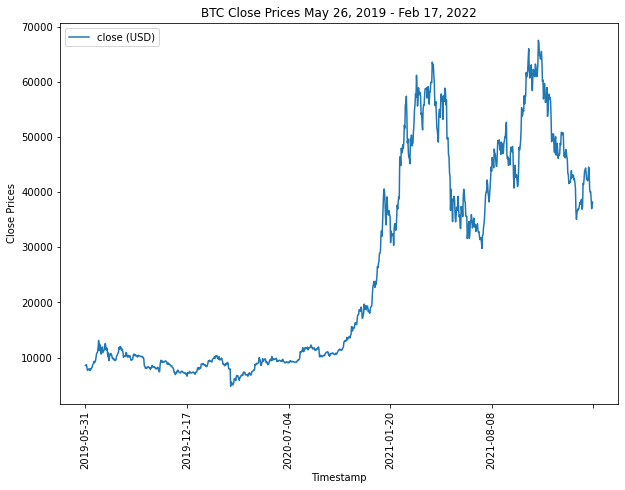

In [138]:
BTC_close.plot.line(
    y='close (USD)',
    xlabel='Timestamp',
    ylabel='Close Prices',
    rot=90,
    title='BTC Close Prices May 26, 2019 - Feb 17, 2022',
    figsize=(10,7)

)

In [139]:
BTC_daily_returns = (BTC_close['close (USD)'].pct_change().dropna()).to_frame()

BTC_daily_returns


,close (USD)
timestamp,
2019-06-01,-0.001278
2019-06-02,0.021291
2019-06-03,-0.069925
2019-06-04,-0.052834
2019-06-05,0.011639
...,...
2022-02-19,0.002620
2022-02-20,-0.042223
2022-02-21,-0.035917


In [140]:
# Generate summary statistics for the `daily_returns_df` DataFrame
BTC_daily_returns.describe()


,close (USD)
count,999.000000
mean,0.002323
std,0.040065
min,-0.395048
25%,-0.016207
50%,0.001340
75%,0.021256
max,0.195361


<AxesSubplot:title={'center':'Daily % Returns'}, xlabel='Days', ylabel='Daily % Returns'>

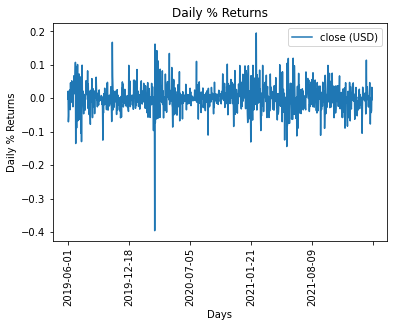

In [141]:
BTC_daily_returns.plot(
    xlabel='Days',
    ylabel='Daily % Returns',
    rot=90,
    title='Daily % Returns'
)

In [142]:
# Calculate and plot the cumulative returns of the 4 fund portfolios and the S&P 500
cumulative_returns = (1 + BTC_daily_returns).cumprod()
columns = ['cumulative_returns']
cumulative_returns.columns = columns

# Review the cumulative returns DataFrame
cumulative_returns.head()

,cumulative_returns
timestamp,
2019-06-01,0.998722
2019-06-02,1.019986
2019-06-03,0.948664
2019-06-04,0.898542
2019-06-05,0.909001


<AxesSubplot:title={'center':'Cumulative % Returns'}, xlabel='Days', ylabel='Cumulative % Returns'>

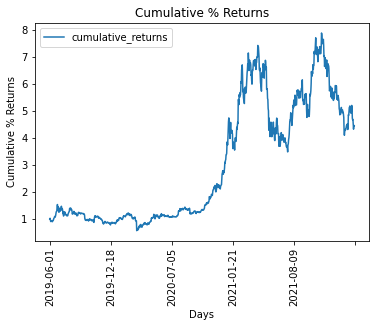

In [143]:
cumulative_returns.plot(

    rot=90,
    xlabel='Days',
    ylabel='Cumulative % Returns',
    title='Cumulative % Returns'
)

### Analyze the Volatility

Analyze the volatility of portfolios and of the S&P 500 Index by using box plots.

<AxesSubplot:title={'center':'Box Plot of Daily Returns'}>

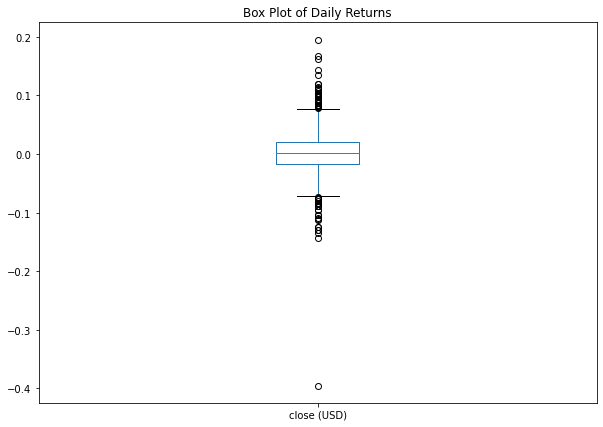

In [144]:
# Use the daily return data to create box plots to visualize the volatility of the 4 funds and the S&P 500 
# Include a title parameter and adjust the figure size
BTC_daily_returns.plot(kind = "box", figsize = (10, 7), title = "Box Plot of Daily Returns")

### Analyze the Risk

Evaluate the risk profile of each portfolio by using the standard deviation and the beta.

In [145]:
# Calculate and sort the standard deviation for all 4 portfolios and the S&P 500
# Review the standard deviations sorted smallest to largest
BTC_daily_std_dv = BTC_daily_returns.std()
BTC_daily_std_dv

close (USD)    0.040065
dtype: float64

In [146]:
# Calculate and sort the annualized standard deviation (252 trading days) of the 4 portfolios and the S&P 500
# Review the annual standard deviations smallest to largest
BTC_annualized_std_dv = BTC_daily_std_dv * np.sqrt(252)
BTC_annualized_std_dv

close (USD)    0.636016
dtype: float64

<AxesSubplot:title={'center':'BTC 21-Day Rolling Standard Deviations'}, xlabel='timestamp'>

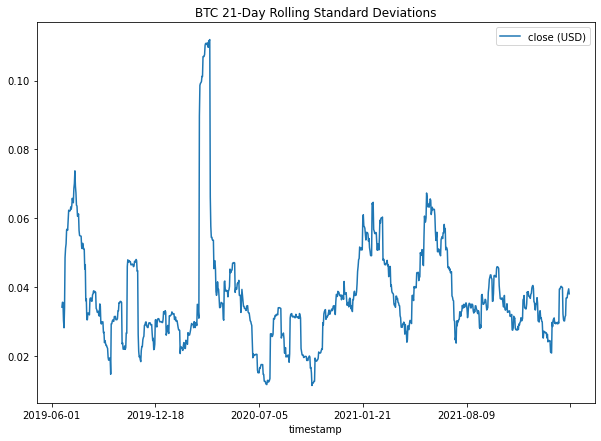

In [147]:
# Using the daily returns DataFrame and a 21-day rolling window, 
# plot the rolling standard deviation of the 4 portfolios and the S&P 500
# Include a title parameter and adjust the figure size
BTC_annualized_std_dv_21roll = BTC_daily_returns.rolling(window=21).std()
BTC_annualized_std_dv_21roll.plot(figsize = (10, 7), title="BTC 21-Day Rolling Standard Deviations")

### Analyze the Risk-Return Profile

To determine the overall risk of an asset or portfolio, quantitative analysts and investment managers consider not only its risk metrics but also its risk-return profile. After all, if you have two portfolios that each offer a 10% return but one has less risk, you’d probably invest in the smaller-risk portfolio. For this reason, you need to consider the Sharpe ratios for each portfolio.

In [148]:
# Use 252 as the number of trading days in the year
year_trading_days = 252

# Calculate the annual average return data for the for fund portfolios and the S&P 500
BTC_annual_avg_return = BTC_daily_returns.mean() * year_trading_days

# Review the annual average returns sorted from lowest to highest

BTC_annual_avg_return

close (USD)    0.585421
dtype: float64

In [149]:
# Calculate the annualized Sharpe Ratios for each of the 4 portfolios and the S&P 500.
sharpe_ratios = BTC_annual_avg_return/BTC_annualized_std_dv


# Review the Sharpe ratios 
sharpe_ratios

close (USD)    0.920449
dtype: float64

In [150]:
# Visualize the Sharpe ratios as a bar chart
# Include a title parameter and adjust the figure size
#sharpe_ratios.plot.bar(title = "Sharpe Ratios")

### Diversify the Portfolio

Your analysis is nearing completion. Now, you need to evaluate how the portfolios react relative to the broader market. Based on your analysis so far, choose two portfolios that you’re most likely to recommend as investment options.

In [96]:
# Calculate the variance of the S&P 500 using a rolling 60-day window.
sp500_var = SP500_daily_returns.rolling(window=60).var().dropna()

sp500_var

In [97]:
# Calculate the covariance using a 60-day rolling window 
# Review the last five rows of the covariance data
BTC_covariance_rolling_60 = BTC_daily_returns.rolling(window=60).cov(BTC_daily_returns)
BTC_covariance_rolling_60.tail()

,close (USD)
timestamp,
2022-02-17,0.001003
2022-02-18,0.001005
2022-02-19,0.000971
2022-02-20,0.000997
2022-02-21,0.000955


In [98]:
# Calculate the beta based on the 60-day rolling covariance compared to the market (S&P 500)
# Review the last five rows of the beta information
BTC_beta_60_roll = (BTC_covariance_rolling_60['close (USD)'] / sp500_var['close']).dropna()
BTC_beta_60_roll

NameError: name 'sp500_var' is not defined

In [99]:
# Calculate the average of the 60-day rolling beta
avg_beta_60_rolling = BTC_beta_60_roll.mean()
avg_beta_60_rolling

NameError: name 'BTC_beta_60_roll' is not defined

In [100]:
# Plot the rolling beta 
# Include a title parameter and adjust the figure size
BTC_beta_60_roll.plot(
    xlabel='Days',
    ylabel='Beta',
    figsize=(10,7), 
    title='BTC SP500 : 60-Day Rolling Variance'
)

NameError: name 'BTC_beta_60_roll' is not defined

In [101]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&outputsize=full&apikey={API_Key}&datatype=csv'
df_base = pd.read_csv(url)
df_base['Date'] = pd.to_datetime(df_base['timestamp'])
df_base = df_base.set_index('Date')
display(df_base.head())


url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=BITW&outputsize=full&apikey={API_Key}&datatype=csv'
df_base2 = pd.read_csv(url)
df_base2['Date'] = pd.to_datetime(df_base2['timestamp'])
df_base2 = df_base2.set_index('Date')
display(df_base2.head())

,timestamp,open,high,low,close,volume
Date,,,,,,
2022-02-22,2022-02-22,431.89,435.5000,425.86,429.57,123130171
2022-02-18,2022-02-18,437.33,438.6600,431.82,434.23,132642896
2022-02-17,2022-02-17,443.22,446.5652,436.42,437.06,102259108
2022-02-16,2022-02-16,443.93,448.0550,441.94,446.60,84863585
2022-02-15,2022-02-15,443.73,446.2800,443.18,446.10,88659503


,timestamp,open,high,low,close,volume
Date,,,,,,
2022-02-18,2022-02-18,33.05,33.150,32.02,33.00,49753
2022-02-17,2022-02-17,34.16,34.250,32.25,33.40,57425
2022-02-16,2022-02-16,34.84,35.315,34.43,35.07,33082
2022-02-15,2022-02-15,35.50,35.880,34.46,34.87,49656
2022-02-14,2022-02-14,32.60,34.800,32.60,33.20,54090


## Monte Carlo Simulation to Forecast 1, 3, 5 yr time periods

In [102]:
def mc_custom(ticker1="SPY", ticker2, num_trading_days=252, num_sim=500, apikey):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&outputsize=full&apikey={api}&datatype=csv'
df_base = pd.read_csv(url)
df_base['Date'] = pd.to_datetime(df_base['timestamp'])
df_base = df_base.set_index('Date')
display(df_base.head())


url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=BITW&outputsize=full&apikey={API_Key}&datatype=csv'
df_base2 = pd.read_csv(url)
df_base2['Date'] = pd.to_datetime(df_base2['timestamp'])
df_base2 = df_base2.set_index('Date')
display(df_base2.head())

SyntaxError: non-default argument follows default argument (3111297280.py, line 1)

In [104]:
spy = df_base[['open', 'high', 'low', 'close', 'volume']]
bitw = df_base2[['open', 'high', 'low', 'close', 'volume']]

to_merge_dict = {"SPY": spy, "BITW": bitw}
merged_df = pd.concat(to_merge_dict.values(), axis=1, keys=to_merge_dict.keys())
merged_df

# Configure the Monte Carlo simulation to forecast 1 year cumulative returns
# The weights are equal
# Run 500 samples.
MC_3_year_cumulative = MCSimulation(
    portfolio_data = merged_df,
    weights=[0.25, 0.75],
    num_simulation = 500,
    num_trading_days = 252 
)

# Review the simulation input data
MC_3_year_cumulative.portfolio_data.tail()

SPY                                                     BITW  \
              open      high     low   close     volume daily_return   open   
Date                                                                          
2022-02-15  443.73  446.2800  443.18  446.10   88659503     0.016127  35.50   
2022-02-16  443.93  448.0550  441.94  446.60   84863585     0.001121  34.84   
2022-02-17  443.22  446.5652  436.42  437.06  102259108    -0.021361  34.16   
2022-02-18  437.33  438.6600  431.82  434.23  132642896    -0.006475  33.05   
2022-02-22  431.89  435.5000  425.86  429.57  123130171    -0.010732    NaN   

                                                        
              high    low  close   volume daily_return  
Date                                                    
2022-02-15  35.880  34.46  34.87  49656.0     0.050301  
2022-02-16  35.315  34.43  35.07  33082.0     0.005736  
2022-02-17  34.250  32.25  33.40  57425.0    -0.047619  
2022-02-18  33.150  32.02  33.00  49753.0    -0.011976  
2022-02-22     NaN    NaN    NaN      NaN     0.000000

In [114]:
one_year_simulation = MCSimulation(
    portfolio_data = merged_df,
    weights=[0.25, 0.75],
    num_simulation = 500,
    num_trading_days = 252
)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Trading Days.'}>

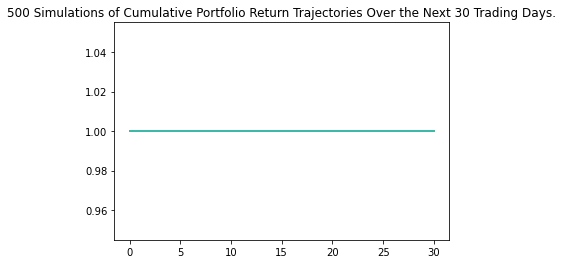

In [112]:
one_year_simulation.calc_cumulative_return()
one_year_simulation.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

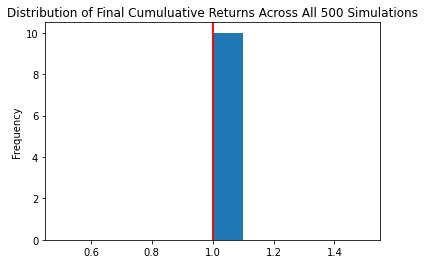

In [113]:
one_year_simulation.plot_distribution()